**Goal**:
Compare the temporal/followup attention extracted from humans with that extracted from the model.

In [35]:
import os

import numpy as np
import pandas as pd
from typing import List, Tuple, Any
import json
import seaborn as sns
import matplotlib.pyplot as plt

import project_path

import matplotlib as mpl
import seaborn as sns
from attwizard.script.utils import load_json_file
from attwizard.script.utils import read_config_file
from tqdm import tqdm

import torch
from torch import nn

In [2]:
%load_ext autoreload
%autoreload 2

In [33]:
HUM_NAME = 'eye_v08'
HUMAN_ATT_FOLDER = os.path.join('..', 'data', 'eye_tracking_attention', HUM_NAME)
EXP_NAME = 'exp_v08'
EXP_CONFIG = read_config_file(os.path.join("..", "config", EXP_NAME + ".yaml"))
MODEL_ATT_FOLDER = os.path.join('..', 'data', 'model_output', EXP_NAME)

In [4]:
from attwizard.script.utils import load_json_file
from typing import Callable
from multiprocessing import Pool
import re


def read_data_in_parallel(
        base_folder: str, 
        file_type_extension: str,
        read_function: Callable, 
        name_extractor_function: str,
        n_processes: int = 4,
        extra_filter_regex: str = None) -> List[Any]:
    """Read the data in parallel."""
    if not file_type_extension[0] == '.':
        file_type_extension = '.' + file_type_extension
    files_to_read = [
        os.path.join(base_folder, f)
        for f in os.listdir(base_folder)
        if f.endswith(file_type_extension)
    ]
    if extra_filter_regex is not None:
        files_to_read = [
            f for f in files_to_read 
            if re.search(extra_filter_regex, f)]
    with Pool(processes=n_processes) as pool:
        data = pool.map(read_function, files_to_read)
        print("n of data read: ", len(data))
        base_names = [
            name_extractor_function(f) 
            for f in files_to_read]
        all_data_dict = {
            k: v for k, v in zip(base_names, data)
        }
    return all_data_dict

# Read Machine Data

In [5]:
def get_source_file_from_filename_machine(filename: str) -> str:
    """Extract the task filename from the name of the machine file."""
    # get basename of the file
    res = filename.split(os.sep)[-1]
    return "_".join(res.split('_')[:2])

In [34]:
ATT_PROCESSING = "naive_max" # followup
PROCESSING_MODES = [a['name'] for a in EXP_CONFIG["analysis_passes"]] 
# ['naive_max', 'followup']
print(f"MODES: {PROCESSING_MODES}")

mutli_approach_container = {}


print('Read metadata (json) from: ', MODEL_ATT_FOLDER)
all_machine_metdata = read_data_in_parallel(
    MODEL_ATT_FOLDER, 'json', load_json_file, get_source_file_from_filename_machine)
print(all_machine_metdata.keys())
mutli_approach_container["metadata"] = all_machine_metdata

for processing_mode in PROCESSING_MODES:
    print("=" * 80)
    model_att_processing_mode_folder = os.path.join(MODEL_ATT_FOLDER, processing_mode)
    print('Read data (npy) from: ', model_att_processing_mode_folder)
    all_machine_matrices = read_data_in_parallel(
        model_att_processing_mode_folder, 'npy', np.load, get_source_file_from_filename_machine)
    print(all_machine_matrices.keys())
    mutli_approach_container[processing_mode] = all_machine_matrices


MODES: ['followup', 'naive_max']
Read metadata (json) from:  ../data/model_output/exp_v08
n of data read:  45
dict_keys(['tree_Q1.cpp', 'hannoi_Q1.cs', 'tree_Q3.cs', 'scheduler_Q1.py', 'hannoi_Q1.cpp', 'triangle_Q1.cs', 'Nqueens_Q1.py', 'Nqueens_Q2.py', 'tree_Q3.py', 'Nqueens_Q3.py', 'countprimes_Q3.cpp', 'hannoi_Q3.cpp', 'scheduler_Q3.cs', 'Nqueens_Q2.cpp', 'scheduler_Q2.cs', 'scheduler_Q1.cs', 'hannoi_Q3.py', 'scheduler_Q3.py', 'triangle_Q2.py', 'triangle_Q3.cpp', 'tree_Q3.cpp', 'countprimes_Q1.cpp', 'scheduler_Q2.py', 'tree_Q1.cs', 'tree_Q2.cpp', 'triangle_Q2.cs', 'hannoi_Q1.py', 'Nqueens_Q3.cs', 'hannoi_Q2.py', 'triangle_Q1.cpp', 'triangle_Q3.cs', 'tree_Q2.cs', 'Nqueens_Q1.cs', 'countprimes_Q2.cpp', 'triangle_Q1.py', 'tree_Q1.py', 'Nqueens_Q1.cpp', 'hannoi_Q3.cs', 'Nqueens_Q3.cpp', 'triangle_Q3.py', 'hannoi_Q2.cs', 'triangle_Q2.cpp', 'hannoi_Q2.cpp', 'Nqueens_Q2.cs', 'tree_Q2.py'])
Read data (npy) from:  ../data/model_output/exp_v08/followup
n of data read:  45
dict_keys(['Nqueens_

# Read Human Data

In [7]:
def get_name_from_human_filename(filename: str) -> str:
    """Extract the name of the user and the task from the filename."""
    res = filename.split(os.sep)[-1]
    res = "_".join(res.split('_')[:2])
    res = res.replace(".json", "")
    return res

In [8]:
all_human_metadata = read_data_in_parallel(
    HUMAN_ATT_FOLDER, 'json', load_json_file, get_name_from_human_filename,
    extra_filter_regex='[a-zA-Z]_[0-9]*.json')
all_human_metadata.keys()

n of data read:  16


dict_keys(['UbagU_0', 'UbagU_2', 'UbagU_3', 'UbagU_4', 'UbeerU_0', 'UbeerU_1', 'UbeerU_2', 'UbeerU_3', 'UbottleU_0', 'UbottleU_1', 'UbottleU_2', 'UbottleU_3', 'UdragonU_1', 'UdragonU_2', 'UdragonU_3', 'UdragonU_4'])

In [9]:
all_human_metadata_matrix = read_data_in_parallel(
    HUMAN_ATT_FOLDER, 'json', load_json_file, get_name_from_human_filename,
    extra_filter_regex='.*_tokens_model.*')
all_human_metadata_matrix.keys()

n of data read:  16


dict_keys(['UbagU_0', 'UbagU_2', 'UbagU_3', 'UbagU_4', 'UbeerU_0', 'UbeerU_1', 'UbeerU_2', 'UbeerU_3', 'UbottleU_0', 'UbottleU_1', 'UbottleU_2', 'UbottleU_3', 'UdragonU_1', 'UdragonU_2', 'UdragonU_3', 'UdragonU_4'])

In [10]:
all_human_matrices = read_data_in_parallel(
    HUMAN_ATT_FOLDER, 'npy', np.load, get_name_from_human_filename,
    extra_filter_regex='.*_tokens_model.*')
all_human_matrices.keys()

n of data read:  16


dict_keys(['UbagU_0', 'UbagU_2', 'UbagU_3', 'UbagU_4', 'UbeerU_0', 'UbeerU_1', 'UbeerU_2', 'UbeerU_3', 'UbottleU_0', 'UbottleU_1', 'UbottleU_2', 'UbottleU_3', 'UdragonU_1', 'UdragonU_2', 'UdragonU_3', 'UdragonU_4'])

# Compare 1 Human vs 1 Machine

In [19]:
TARGET_HUMAN = 'UdragonU_1' #'UbeerU_0'
TARGET_MODE = 'followup'

In [12]:
matrix_human = all_human_matrices[TARGET_HUMAN]
metadata_human = all_human_metadata[TARGET_HUMAN]
metadata_human_matrix = all_human_metadata_matrix[TARGET_HUMAN]
# remove the last token since it is a normal new line
matrix_human = matrix_human[:-1, :-1]
matrix_human.shape

(291, 291)

In [20]:
# get corresponding machine matrix
metadata = all_human_metadata[TARGET_HUMAN]
source_code_filename = metadata['source_code'].split('/')[-1]
matrix_machine = mutli_approach_container[TARGET_MODE][source_code_filename]
# note that the machine has more tokens than the human
# because it includes the predicted text
# thus consider only the prompt tokens
metadata_machine = all_machine_metdata[source_code_filename]
n_tokens = len(metadata_machine['tokens_prompt'])
matrix_machine = matrix_machine[:n_tokens, :n_tokens]
matrix_machine.shape


(290, 290)

## Compare the two tokenizations

In [21]:
def visual_check(
        machine_prediction_tokens: List[str],
        to_compare: List[str],
        codeattention_tokenization: List[str],
        n_elements: int = None):
    for i in range(max(len(machine_prediction_tokens), len(to_compare))):
        if i >= len(machine_prediction_tokens):
            machine_prediction_tokens.append("EMPTY")
        if i >= len(to_compare):
            to_compare.append("EMPTY")
        print(f"{i}) ", machine_prediction_tokens[i], "\t"*5, ">", to_compare[i], "<")
        print("codeattention_tokenization: ", [t['t'] for t in codeattention_tokenization if t['i'] == i])
        if n_elements is not None and i == n_elements:
            break

visual_check(
    machine_prediction_tokens=metadata_machine["tokens_prompt"],
    to_compare=metadata_human_matrix["model_tokens"],
    codeattention_tokenization=metadata_human_matrix["tokenization"],
    n_elements=5
)

0)  / 					 > / <
codeattention_tokenization:  ['/']
1)  ******************************** 					 > ******************************** <
codeattention_tokenization:  ['********************************']
2)  ******************************** 					 > ******************************** <
codeattention_tokenization:  ['********************************']
3)  ******************************** 					 > ******************************** <
codeattention_tokenization:  ['********************************']
4)  */ 					 > */ <
codeattention_tokenization:  ['*/']
5)  ĊĊ 					 > 

 <
codeattention_tokenization:  ['\n', '\n']


## Compute the Distance

In [22]:
def normalize_matrix_by_line(matrix: np.ndarray) -> np.ndarray:
    """Normalize the matrix by line."""
    summation_vector = matrix.sum(axis=1, keepdims=True)
    # replace nan with 1
    summation_vector = np.nan_to_num(summation_vector, nan=1)
    res = matrix / summation_vector
    return np.nan_to_num(res, nan=0)

matrix_human_section = matrix_human[:n_tokens, :n_tokens]

matrix_human_normalized = normalize_matrix_by_line(matrix_human_section)
matrix_machine_normalized = normalize_matrix_by_line(matrix_machine)

/tmp/ipykernel_85203/2631953373.py:6: RuntimeWarning: invalid value encountered in divide
  res = matrix / summation_vector


In [23]:
loss = nn.MSELoss()
matrix_human_normalized = matrix_human_normalized
l = loss(
    torch.from_numpy(matrix_human_normalized), 
    torch.from_numpy(matrix_machine_normalized)
)
l.item()

1.5025740140117705e-05

Target mode: followup


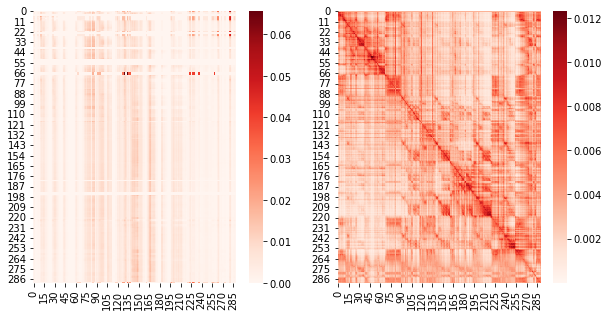

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.heatmap(matrix_human_normalized, cmap='Reds', ax=axes[0])
sns.heatmap(matrix_machine_normalized, cmap='Reds', ax=axes[1])
print(f"Target mode: {TARGET_MODE}")

## Loop Over all Human Tasks

In [53]:
loss = nn.MSELoss() #nn.KLDivLoss #nn.MSELoss()
res_modes = {}
records = []

for mode in PROCESSING_MODES:
    # initialize dictionary
    res_modes[mode] = {
        "list_losses": [],
        "list_weights": [],
    }
    for target_user_task in tqdm(all_human_matrices.keys()):
        matrix_human = all_human_matrices[target_user_task]
        metadata_human = all_human_metadata[target_user_task]
        metadata_human_matrix = all_human_metadata_matrix[target_user_task]
        # remove the last token since it is a normal new line
        #matrix_human = matrix_human[:-1, :-1]
        print(f"Human data ({target_user_task}): {matrix_human.shape}")
        # get corresponding machine matrix
        source_code_filename = metadata_human['source_code'].split('/')[-1]
        try:
            matrix_machine = mutli_approach_container[mode][source_code_filename]
        except KeyError as e:
            print(f"\tNo machine data for {source_code_filename}. Skipping.")
            continue
        # note that the machine has more tokens than the human
        # because it includes the predicted text
        # thus consider only the prompt tokens
        metadata_machine = all_machine_metdata[source_code_filename]
        n_tokens = len(metadata_machine['tokens_prompt'])
        matrix_machine = matrix_machine[:n_tokens, :n_tokens]
        print(f"Corresponding machine data ({source_code_filename}): {matrix_machine.shape}")
        # normalize by line (so to have probabilities)
        matrix_human = matrix_human[:n_tokens, :n_tokens]
        matrix_human_normalized = normalize_matrix_by_line(matrix_human)
        matrix_machine_normalized = normalize_matrix_by_line(matrix_machine)
        # compute the loss
        for i in tqdm(range(n_tokens)):
            current_loss = loss(
                torch.from_numpy(matrix_human_normalized)[i, :], 
                torch.from_numpy(matrix_machine_normalized)[i, :]
            )
            # weight each row by the attention it receives in the human 
            # (the attention is the sum of the values in the row)
            current_weight = matrix_human[i, :].sum()
            res_modes[mode]['list_weights'].append(current_weight)
            res_modes[mode]['list_losses'].append(current_loss.item())

            weights = res_modes[mode]['list_weights']
            losses = res_modes[mode]['list_losses']

            records.append({
                "mode": mode,
                "loss": current_loss.item(),
                "weight": current_weight,
                "target_user_task": target_user_task,
                "source_code_filename": source_code_filename,
            })

df_raw_comparisons = pd.DataFrame.from_records(records)


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_85203/2631953373.py:6: RuntimeWarning: invalid value encountered in divide
  res = matrix / summation_vector


Human data (UbagU_0): (216, 216)
Corresponding machine data (hannoi_Q2.py): (216, 216)


100%|██████████| 216/216 [00:00<00:00, 19245.65it/s]


Human data (UbagU_2): (507, 507)
Corresponding machine data (tree_Q2.py): (507, 507)


100%|██████████| 507/507 [00:00<00:00, 21644.11it/s]


Human data (UbagU_3): (519, 519)
Corresponding machine data (triangle_Q1.py): (519, 519)


100%|██████████| 519/519 [00:00<00:00, 21703.76it/s]


Human data (UbagU_4): (768, 768)
	No machine data for multithread_Q1.py. Skipping.
Human data (UbeerU_0): (226, 226)
Corresponding machine data (hannoi_Q1.py): (225, 225)


100%|██████████| 225/225 [00:00<00:00, 21229.58it/s]


Human data (UbeerU_1): (518, 518)
Corresponding machine data (tree_Q1.py): (518, 518)


 38%|███▊      | 6/16 [00:00<00:00, 50.42it/s]

Human data (UbeerU_2): (518, 518)
Corresponding machine data (triangle_Q3.py): (518, 518)


100%|██████████| 518/518 [00:00<00:00, 21915.63it/s]


Human data (UbeerU_3): (756, 756)
	No machine data for multithread_Q2.py. Skipping.
Human data (UbottleU_0): (216, 216)
Corresponding machine data (hannoi_Q2.py): (216, 216)


100%|██████████| 216/216 [00:00<00:00, 21269.39it/s]


Human data (UbottleU_1): (507, 507)
Corresponding machine data (tree_Q2.py): (507, 507)


100%|██████████| 507/507 [00:00<00:00, 21606.94it/s]


Human data (UbottleU_2): (519, 519)
Corresponding machine data (triangle_Q1.py): (519, 519)


 75%|███████▌  | 12/16 [00:00<00:00, 55.16it/s]

Human data (UbottleU_3): (768, 768)
	No machine data for multithread_Q1.py. Skipping.
Human data (UdragonU_1): (292, 292)
Corresponding machine data (hannoi_Q1.cpp): (290, 290)


100%|██████████| 290/290 [00:00<00:00, 21428.16it/s]


Human data (UdragonU_2): (599, 599)
Corresponding machine data (tree_Q2.cpp): (597, 597)


100%|██████████| 597/597 [00:00<00:00, 21929.13it/s]


Human data (UdragonU_3): (693, 693)
Corresponding machine data (triangle_Q1.cpp): (691, 691)


100%|██████████| 16/16 [00:00<00:00, 50.53it/s]


Human data (UdragonU_4): (813, 813)
	No machine data for multithread_Q2.cpp. Skipping.


  0%|          | 0/16 [00:00<?, ?it/s]

Human data (UbagU_0): (216, 216)
Corresponding machine data (hannoi_Q2.py): (216, 216)


100%|██████████| 216/216 [00:00<00:00, 21226.53it/s]


Human data (UbagU_2): (507, 507)
Corresponding machine data (tree_Q2.py): (507, 507)


100%|██████████| 507/507 [00:00<00:00, 21469.73it/s]


Human data (UbagU_3): (519, 519)
Corresponding machine data (triangle_Q1.py): (519, 519)


100%|██████████| 519/519 [00:00<00:00, 21719.35it/s]


Human data (UbagU_4): (768, 768)
	No machine data for multithread_Q1.py. Skipping.
Human data (UbeerU_0): (226, 226)
Corresponding machine data (hannoi_Q1.py): (225, 225)


100%|██████████| 225/225 [00:00<00:00, 21190.01it/s]


Human data (UbeerU_1): (518, 518)
Corresponding machine data (tree_Q1.py): (518, 518)


 38%|███▊      | 6/16 [00:00<00:00, 51.61it/s]

Human data (UbeerU_2): (518, 518)
Corresponding machine data (triangle_Q3.py): (518, 518)


100%|██████████| 518/518 [00:00<00:00, 20812.21it/s]


Human data (UbeerU_3): (756, 756)
	No machine data for multithread_Q2.py. Skipping.
Human data (UbottleU_0): (216, 216)
Corresponding machine data (hannoi_Q2.py): (216, 216)


100%|██████████| 216/216 [00:00<00:00, 21832.17it/s]


Human data (UbottleU_1): (507, 507)
Corresponding machine data (tree_Q2.py): (507, 507)


100%|██████████| 507/507 [00:00<00:00, 21517.74it/s]


Human data (UbottleU_2): (519, 519)
Corresponding machine data (triangle_Q1.py): (519, 519)


 75%|███████▌  | 12/16 [00:00<00:00, 55.97it/s]

Human data (UbottleU_3): (768, 768)
	No machine data for multithread_Q1.py. Skipping.
Human data (UdragonU_1): (292, 292)
Corresponding machine data (hannoi_Q1.cpp): (290, 290)


100%|██████████| 290/290 [00:00<00:00, 21210.32it/s]


Human data (UdragonU_2): (599, 599)
Corresponding machine data (tree_Q2.cpp): (597, 597)


100%|██████████| 597/597 [00:00<00:00, 21092.53it/s]


Human data (UdragonU_3): (693, 693)
Corresponding machine data (triangle_Q1.cpp): (691, 691)


100%|██████████| 16/16 [00:00<00:00, 51.81it/s]


Human data (UdragonU_4): (813, 813)
	No machine data for multithread_Q2.cpp. Skipping.


In [54]:
records = []

for mode in PROCESSING_MODES:
    print("=" * 80)
    print(f"MODE: {mode}")
    weights = res_modes[mode]['list_weights']
    losses = res_modes[mode]['list_losses']
    wighted_average_loss = np.dot(losses, weights) / sum(weights)
    print(f'Total valid records: {len(losses)}')
    print(f"Average loss: {np.mean(losses):.5f}")
    print(f"(Weighted) Average loss: {wighted_average_loss:.5f}")
    records.append({
        "mode": mode,
        "average_loss": np.mean(losses),
        "weighted_average_loss": wighted_average_loss,
        "n_comparisons": len(losses),
    })

df = pd.DataFrame.from_records(records)
df.head()

MODE: followup
Total valid records: 5323
Average loss: 0.00001
(Weighted) Average loss: 0.00001
MODE: naive_max
Total valid records: 5323
Average loss: 0.00008
(Weighted) Average loss: 0.00006


,mode,average_loss,weighted_average_loss,n_comparisons
0,followup,0.000013,0.000010,5323
1,naive_max,0.000077,0.000056,5323


(0.0, 0.0005)

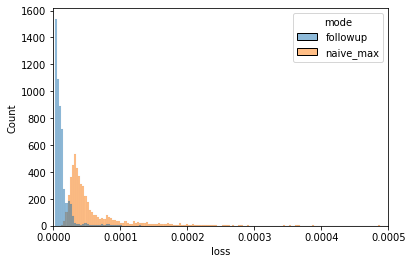

In [60]:
sns.histplot(
    data=df_raw_comparisons,
    hue='mode',
    x='loss'
)
plt.xlim(0, 0.0005)